In [229]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [230]:
# Maak een pandas dataframe van de train.csv file
df = pd.read_csv('train.csv')

In [172]:
df.head()  # bekijk de eerste 5 rijen krijg een idee van de features
# PassengerId lijkt niet nuttig voor de voorspelling
# Name waarshijnlijk ook niet nuttig

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [173]:
df.info()  # 8693 datapunten met 14 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [174]:
df.isnull().sum()  # aantal 0 null waardes per feature
# Alle features hebben null waardes behalve PassengerId en Transported
# Bijde zijn niet relevant voor de voorspelling
# Alle relevante features moeten dus worden opgeschoond

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [175]:
# Bekijk de statistische waardes van de features, dit is nuttig voor numerieke features
def count_plot(column):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=column, data=df)  # countplot van de feature
    plt.title(f'{column} count')
    plt.x_label = column
    plt.y_label = 'count'
    plt.show()
    return df[column].value_counts()  # return de count per waarde

In [176]:
def hist_plot(column, bins=10):
    plt.figure(figsize=(10, 5))
    sns.histplot(x=column, data=df, bins=bins)  # histplot van de feature
    plt.title(f'{column} hist')
    plt.x_label = column
    plt.y_label = 'count'
    plt.show()
    return df[column].value_counts()  # return de count per waarde

## Data bestuderen

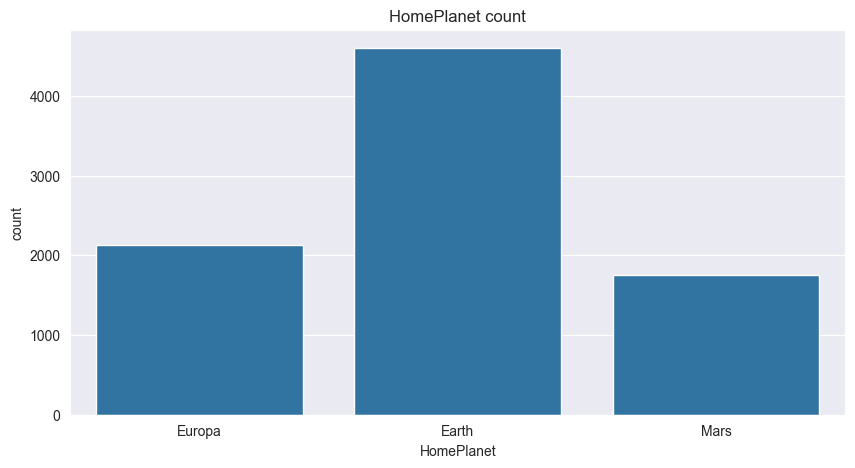

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [177]:
# HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
count_plot('HomePlanet')

# earth is de meest voorkomende waarde

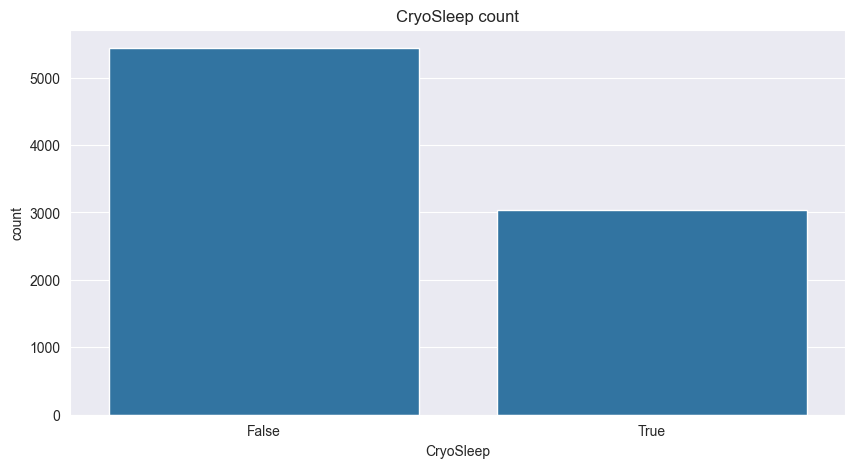

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

In [178]:
# CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
count_plot('CryoSleep')

# False is de meest voorkomende waarde

In [179]:
# Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
# count_plot('Cabin') werkt niet omdat het een string is
# deck/num/side kan opgesplitst worden in 3 features ipv 1
# Cabin heeft 199 null waardes deze moeten eerst worden gevuld

df['Cabin'].fillna(0)  # vul de null waardes 
df['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [180]:
df['Cabin'] = df['Cabin'].str.split('/')  # splits de string op / en maak 3 nieuwe features
df['Cabin']

0          [B, 0, P]
1          [F, 0, S]
2          [A, 0, S]
3          [A, 0, S]
4          [F, 1, S]
            ...     
8688      [A, 98, P]
8689    [G, 1499, S]
8690    [G, 1500, S]
8691     [E, 608, S]
8692     [E, 608, S]
Name: Cabin, Length: 8693, dtype: object

In [181]:
# get_cabin_deck - haalt de deck uit de cabin feature
def get_cabin_deck(cabin):
    if type(cabin) == float:  # als cabin een float is return 0
        return 0
    if cabin == 0:  # als cabin 0 is return 0
        return 0
    else:  # anders return de deck
        return cabin[0]

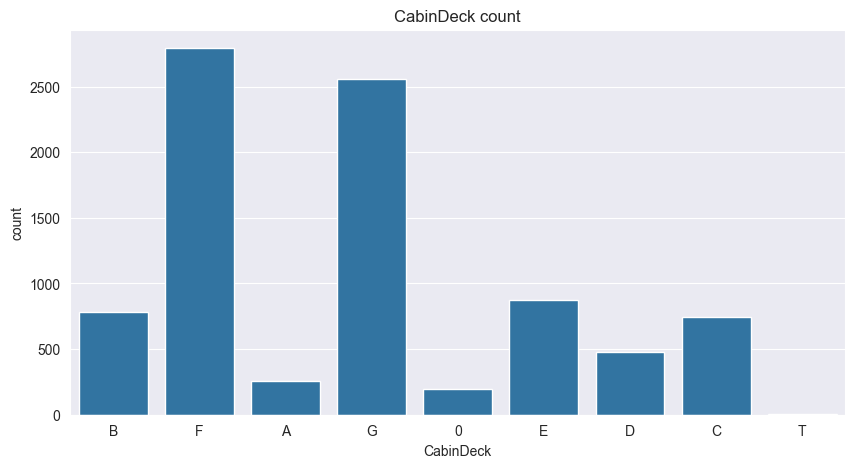

CabinDeck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
0     199
T       5
Name: count, dtype: int64

In [182]:
df['CabinDeck'] = df['Cabin'].apply(get_cabin_deck)  # maak een nieuwe feature, CabinDeck
count_plot('CabinDeck')  # bekijk de count van CabinDeck

# D, A, O en T zijn erg klein

In [183]:
# get_cabin_num - haalt de num uit de cabin feature
def get_cabin_num(cabin):
    if type(cabin) == float:  # als cabin een float is return 0
        return 0
    if cabin == 0:  # als cabin 0 is return 0
        return 0
    else:  # anders return de num
        return cabin[1]

In [184]:
df['CabinNum'] = df['Cabin'].apply(get_cabin_num)  # maak een nieuwe feature, CabinNum
#count_plot('CabinNum') # bekijk de count van CabinNum

# Niks nuttigs uit op te merken omdat er te veel unieke waardes zijn

In [185]:
# get_cabin_side - haalt de side uit de cabin feature
def get_cabin_side(cabin):
    if type(cabin) == float:  # als cabin een float is return 0
        return 0
    if cabin == 0:  # als cabin 0 is return 0
        return 0
    else:  # anders return de side
        return cabin[2]

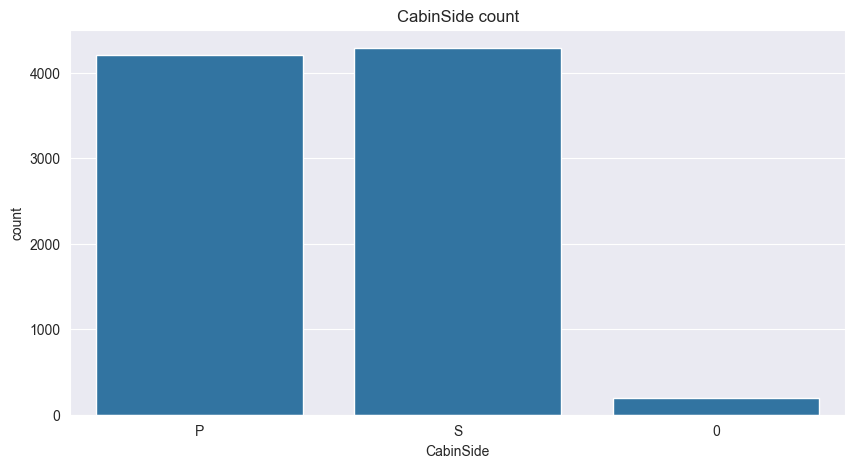

CabinSide
S    4288
P    4206
0     199
Name: count, dtype: int64

In [186]:
df['CabinSide'] = df['Cabin'].apply(get_cabin_side)  # maak een nieuwe feature, CabinSide
count_plot('CabinSide')  # bekijk de count van CabinSide

# O is erg klein

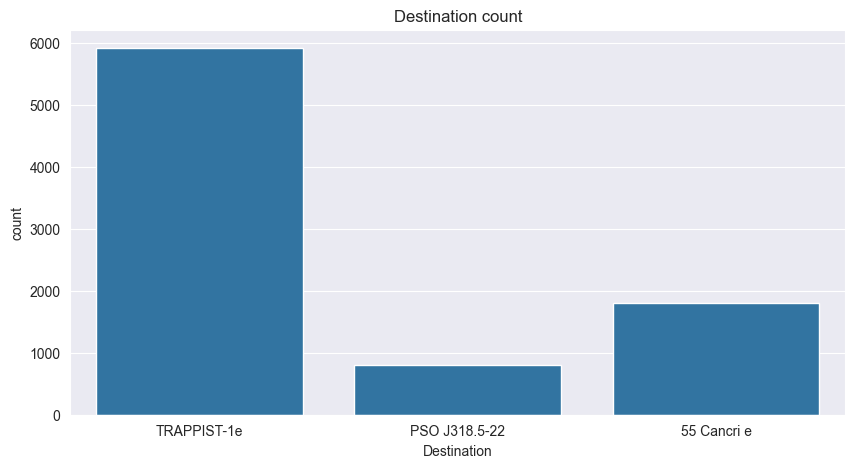

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [187]:
# Destination - The planet the passenger will be debarking to.
count_plot('Destination')

# TRAPPIST-1e komt verreweg het meest voor

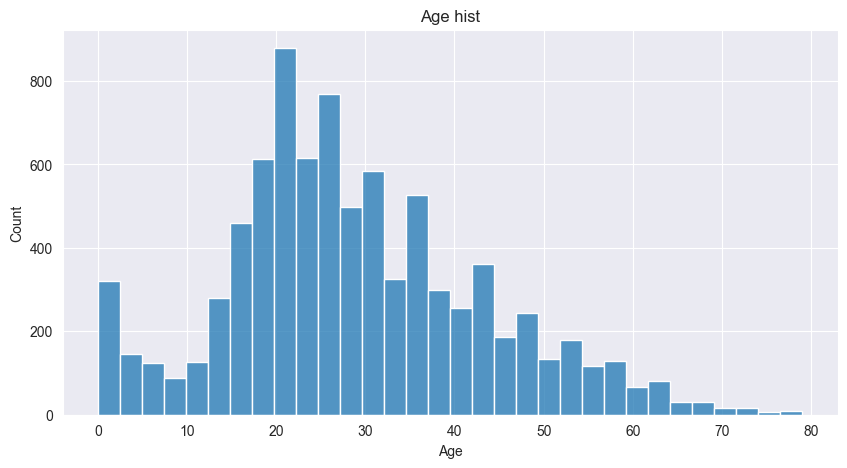

Age
24.0    324
18.0    320
21.0    311
19.0    293
23.0    292
       ... 
72.0      4
78.0      3
79.0      3
76.0      2
77.0      2
Name: count, Length: 80, dtype: int64

In [188]:
# Age - The age of the passenger.
hist_plot('Age', 32)

# Uitbijters zijn te zien

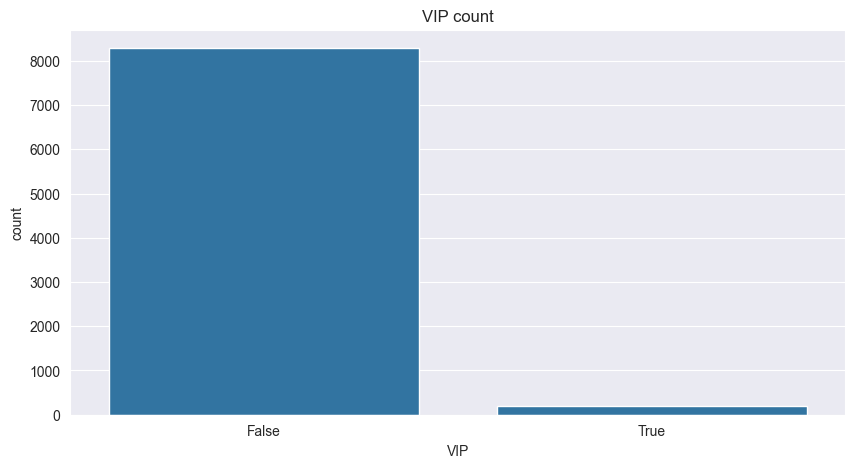

VIP
False    8291
True      199
Name: count, dtype: int64

In [189]:
# VIP - Whether the passenger has paid for special VIP service during the voyage.
count_plot('VIP')

# bijna geen true values feature is misschien niet nuttig

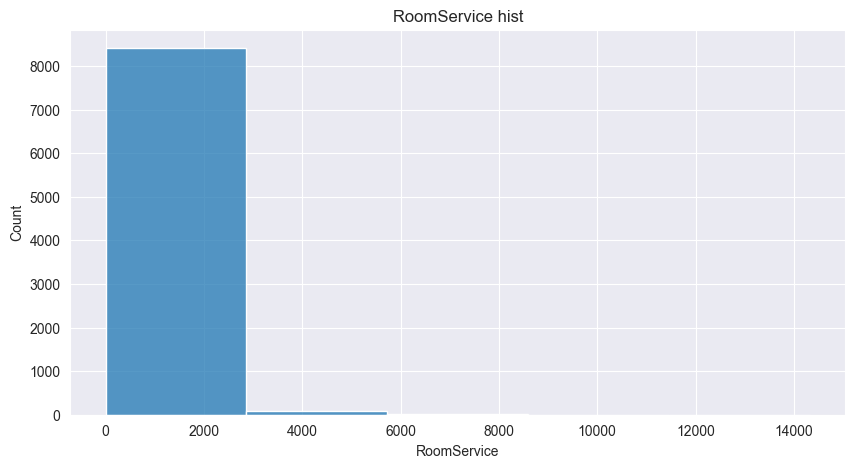

RoomService
0.0       5577
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
1612.0       1
2598.0       1
632.0        1
378.0        1
745.0        1
Name: count, Length: 1273, dtype: int64

In [190]:
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
hist_plot('RoomService', 5)

# Extreme uitbijters zijn te zien

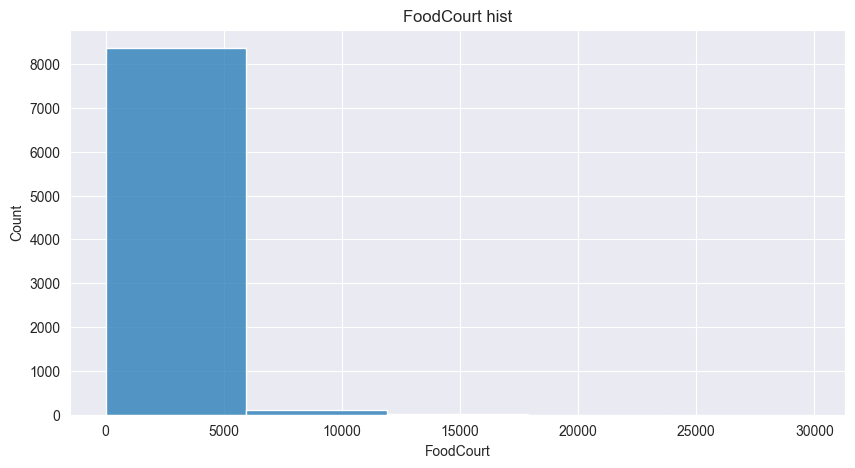

FoodCourt
0.0       5456
1.0        116
2.0         75
3.0         53
4.0         53
          ... 
3846.0       1
5193.0       1
312.0        1
827.0        1
4688.0       1
Name: count, Length: 1507, dtype: int64

In [191]:
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
hist_plot('FoodCourt', 5)

# Extreme uitbijters zijn te zien

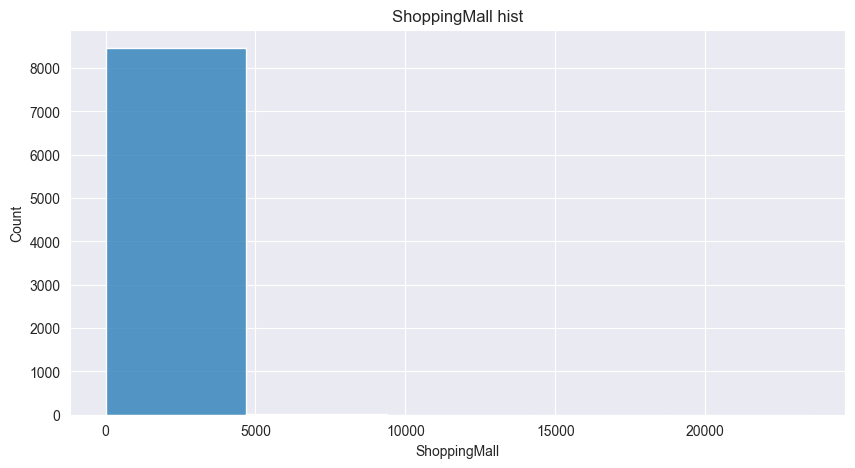

ShoppingMall
0.0       5587
1.0        153
2.0         80
3.0         59
4.0         45
          ... 
3627.0       1
2074.0       1
871.0        1
742.0        1
1872.0       1
Name: count, Length: 1115, dtype: int64

In [192]:
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
hist_plot('ShoppingMall', 5)

# Extreme uitbijters zijn te zien

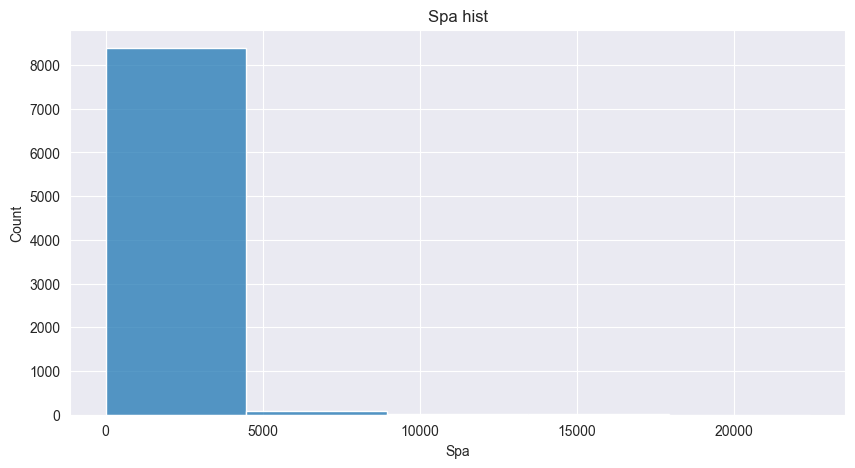

Spa
0.0       5324
1.0        146
2.0        105
5.0         53
3.0         53
          ... 
273.0        1
2581.0       1
2948.0       1
3778.0       1
1643.0       1
Name: count, Length: 1327, dtype: int64

In [193]:
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
hist_plot('Spa', 5)

# Extreme uitbijters zijn te zien

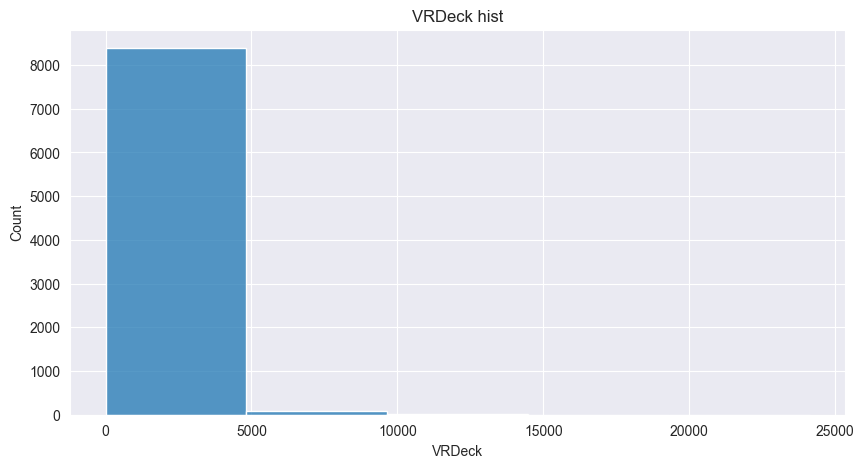

VRDeck
0.0       5495
1.0        139
2.0         70
3.0         56
5.0         51
          ... 
408.0        1
876.0        1
2891.0       1
2102.0       1
3235.0       1
Name: count, Length: 1306, dtype: int64

In [194]:
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
hist_plot('VRDeck', 5)

# Extreme uitbijters zijn te zien

## Data opschonen

In [205]:
print(df.shape)
print(df.isnull().sum())  # aantal null waardes per feature

#df_nulls_removed = df.dropna()  # verwijder alle null waardes
#print(df_nulls_removed.shape)
#print(df_nulls_removed.isnull().sum())

df = df.dropna()

# 2087 datapunten zijn verwijderd, dat zijn er best veel, misschien is het beter om de null waardes te vullen

(6606, 22)
PassengerId            0
HomePlanet             0
CryoSleep              0
Cabin                  0
Destination            0
Age                    0
VIP                    0
RoomService            0
FoodCourt              0
ShoppingMall           0
Spa                    0
VRDeck                 0
Name                   0
Transported            0
CabinDeck              0
CabinNum               0
CabinSide              0
RoomService_binary     0
FoodCourt_binary       0
ShoppingMall_binary    0
Spa_binary             0
VRDeck_binary          0
dtype: int64


In [206]:
# RoomService had extreme uitbijters, deze worden verwijderd
# df['RoomService_cleaned'] = df['RoomService'].clip(upper=1000)

# Omdat er zulke uitbijters zijn is het misschien handig om een binary feature te maken
# 0 = no roomservice, 1 = roomservice
df['RoomService_binary'] = df['RoomService'].apply(lambda x: 0 if x == 0 else 1)

In [207]:
# FoodCourt had extreme uitbijters, deze worden verwijderd
# df['FoodCourt_cleaned'] = df['FoodCourt'].clip(upper=1000)

# 0 = no foodcourt, 1 = foodcourt
df['FoodCourt_binary'] = df['FoodCourt'].apply(lambda x: 0 if x == 0 else 1)

In [208]:
# ShoppingMall had extreme uitbijters, deze worden verwijderd
# df['ShoppingMall_cleaned'] = df['ShoppingMall'].clip(upper=1000)

# 0 = no shoppingmall, 1 = shoppingmall
df['ShoppingMall_binary'] = df['ShoppingMall'].apply(lambda x: 0 if x == 0 else 1)

In [209]:
# Spa had extreme uitbijters, deze worden verwijderd
# df['Spa_cleaned'] = df['Spa'].clip(upper=1000)

# 0 = no spa, 1 = spa
df['Spa_binary'] = df['Spa'].apply(lambda x: 0 if x == 0 else 1)

In [210]:
# VRDeck had extreme uitbijters, deze worden verwijderd
# df['VRDeck_cleaned'] = df['VRDeck'].clip(upper=1000)

# 0 = no VRDeck, 1 = VRDeck
df['VRDeck_binary'] = df['VRDeck'].apply(lambda x: 0 if x == 0 else 1)

In [211]:
features = ['HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinSide', 'Destination', 'Age', 'VIP', 'RoomService_binary', 'FoodCourt_binary', 'ShoppingMall_binary', 'Spa_binary',
            'VRDeck_binary']

In [212]:
# Maak een nieuwe dataframe met alleen de gekozen features
df_model = pd.get_dummies(df, columns=features)
df_model.shape

(6606, 120)

In [213]:
for i in df_model.columns:
    print('"' + i + '",')

"PassengerId",
"Cabin",
"RoomService",
"FoodCourt",
"ShoppingMall",
"Spa",
"VRDeck",
"Name",
"Transported",
"CabinNum",
"HomePlanet_Earth",
"HomePlanet_Europa",
"HomePlanet_Mars",
"CryoSleep_False",
"CryoSleep_True",
"CabinDeck_A",
"CabinDeck_B",
"CabinDeck_C",
"CabinDeck_D",
"CabinDeck_E",
"CabinDeck_F",
"CabinDeck_G",
"CabinDeck_T",
"CabinSide_P",
"CabinSide_S",
"Destination_55 Cancri e",
"Destination_PSO J318.5-22",
"Destination_TRAPPIST-1e",
"Age_0.0",
"Age_1.0",
"Age_2.0",
"Age_3.0",
"Age_4.0",
"Age_5.0",
"Age_6.0",
"Age_7.0",
"Age_8.0",
"Age_9.0",
"Age_10.0",
"Age_11.0",
"Age_12.0",
"Age_13.0",
"Age_14.0",
"Age_15.0",
"Age_16.0",
"Age_17.0",
"Age_18.0",
"Age_19.0",
"Age_20.0",
"Age_21.0",
"Age_22.0",
"Age_23.0",
"Age_24.0",
"Age_25.0",
"Age_26.0",
"Age_27.0",
"Age_28.0",
"Age_29.0",
"Age_30.0",
"Age_31.0",
"Age_32.0",
"Age_33.0",
"Age_34.0",
"Age_35.0",
"Age_36.0",
"Age_37.0",
"Age_38.0",
"Age_39.0",
"Age_40.0",
"Age_41.0",
"Age_42.0",
"Age_43.0",
"Age_44.0",
"Age_45.0",
"Age_46.

In [219]:
# 'PassengerId','Cabin', 
features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'CabinNum', 'HomePlanet_Earth', 'HomePlanet_Europa', 
            'HomePlanet_Mars', 'CryoSleep_False', 'CryoSleep_True', 'CabinDeck_A',
            'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F', 'CabinDeck_G', 'CabinDeck_T', 'CabinSide_P', 'CabinSide_S', 'Destination_55 Cancri e',
            'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', #'Age_0.0', 'Age_1.0', 'Age_2.0', 'Age_3.0', 'Age_4.0', 'Age_5.0', 'Age_6.0', 'Age_7.0', 'Age_8.0', 'Age_9.0',
            # 'Age_10.0', 'Age_11.0', 'Age_12.0', 'Age_13.0', 'Age_14.0', 'Age_15.0', 'Age_16.0', 'Age_17.0', 'Age_18.0', 'Age_19.0', 'Age_20.0', 'Age_21.0', 'Age_22.0', 'Age_23.0',
            # 'Age_24.0', 'Age_25.0', 'Age_26.0', 'Age_27.0', 'Age_28.0', 'Age_29.0', 'Age_30.0', 'Age_31.0', 'Age_32.0', 'Age_33.0', 'Age_34.0', 'Age_35.0', 'Age_36.0', 'Age_37.0',
            # 'Age_38.0', 'Age_39.0', 'Age_40.0', 'Age_41.0', 'Age_42.0', 'Age_43.0', 'Age_44.0', 'Age_45.0', 'Age_46.0', 'Age_47.0', 'Age_48.0', 'Age_49.0', 'Age_50.0', 'Age_51.0',
            # 'Age_52.0', 'Age_53.0', 'Age_54.0', 'Age_55.0', 'Age_56.0', 'Age_57.0', 'Age_58.0', 'Age_59.0', 'Age_60.0', 'Age_61.0', 'Age_62.0', 'Age_63.0', 'Age_64.0', 'Age_65.0',
            # 'Age_66.0', 'Age_67.0', 'Age_68.0', 'Age_69.0', 'Age_70.0', 'Age_71.0', 'Age_72.0', 'Age_73.0', 'Age_74.0', 'Age_75.0', 'Age_76.0', 'Age_77.0', 'Age_78.0', 'Age_79.0',
            'VIP_False', 'VIP_True', 'RoomService_binary_0', 'RoomService_binary_1', 'FoodCourt_binary_0', 'FoodCourt_binary_1', 'ShoppingMall_binary_0', 'ShoppingMall_binary_1',
            'Spa_binary_0', 'Spa_binary_1', 'VRDeck_binary_0', 'VRDeck_binary_1']
target = ['Transported']

X = df_model[features]
y = df_model[target]

In [220]:
def grid_search(model, parameters, cv=3):
    grid = GridSearchCV(model, parameters, cv=cv, scoring='accuracy', verbose=3, n_jobs=64)
    grid.fit(X, y)
   
    print(f'Best parameters: {grid.best_params_}')

In [217]:
# Random Forest 
# Uitleg random forest:

from sklearn.ensemble import RandomForestClassifier

# np.arange(start, stop, step)
rf = RandomForestClassifier()
parameters = {
    'n_estimators': np.arange(50, 450, 50),
    'max_depth': np.arange(2, 16, 2),
    'min_samples_leaf': np.arange(1, 15, 1),
    'criterion': ['gini', 'entropy']
}

In [218]:
df_rf = grid_search(rf, parameters)
df_rf

D:\Programming\ML\venv\lib\site-packages\joblib\externals\loky\process_executor.py:1076: UserWarning: On Windows, max_workers cannot exceed 60 due to limitations of the operating system.
  warnings.warn(


Fitting 3 folds for each of 1568 candidates, totalling 4704 fits


ValueError: 
All the 4704 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4704 fits failed with the following error:
TypeError: float() argument must be a string or a number, not 'list'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "D:\Programming\ML\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programming\ML\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "D:\Programming\ML\venv\lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "D:\Programming\ML\venv\lib\site-packages\sklearn\base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "D:\Programming\ML\venv\lib\site-packages\sklearn\utils\validation.py", line 1146, in check_X_y
    X = check_array(
  File "D:\Programming\ML\venv\lib\site-packages\sklearn\utils\validation.py", line 836, in check_array
    array = array.astype(new_dtype)
  File "D:\Programming\ML\venv\lib\site-packages\pandas\core\generic.py", line 6534, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "D:\Programming\ML\venv\lib\site-packages\pandas\core\internals\managers.py", line 414, in astype
    return self.apply(
  File "D:\Programming\ML\venv\lib\site-packages\pandas\core\internals\managers.py", line 354, in apply
    applied = getattr(b, f)(**kwargs)
  File "D:\Programming\ML\venv\lib\site-packages\pandas\core\internals\blocks.py", line 616, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "D:\Programming\ML\venv\lib\site-packages\pandas\core\dtypes\astype.py", line 238, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
  File "D:\Programming\ML\venv\lib\site-packages\pandas\core\dtypes\astype.py", line 183, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
  File "D:\Programming\ML\venv\lib\site-packages\pandas\core\dtypes\astype.py", line 134, in _astype_nansafe
    return arr.astype(dtype, copy=True)
ValueError: setting an array element with a sequence.


In [168]:
# Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
parameters_gb = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': np.arange(0.1, 1.1, 0.1),
    'n_estimators': np.arange(50, 450, 50),
    'max_depth': np.arange(2, 16, 2),
}

In [169]:
df_gb = grid_search(gb, parameters_gb)
df_gb

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "C:\Users\djurr\AppData\Local\Programs\Python\Python39\lib\threading.py", line 954, in _bootstrap_inner
    self.run()
  File "D:\Programming\ML\venv\lib\site-packages\joblib\externals\loky\process_executor.py", line 596, in run
    result_item, is_broken, bpe = self.wait_result_broken_or_wakeup()
  File "D:\Programming\ML\venv\lib\site-packages\joblib\externals\loky\process_executor.py", line 654, in wait_result_broken_or_wakeup
    ready = wait(readers + worker_sentinels)
  File "C:\Users\djurr\AppData\Local\Programs\Python\Python39\lib\multiprocessing\connection.py", line 884, in wait
    ready_handles = _exhaustive_wait(waithandle_to_obj.keys(), timeout)
  File "C:\Users\djurr\AppData\Local\Programs\Python\Python39\lib\multiprocessing\connection.py", line 816, in _exhaustive_wait
    res = _winapi.WaitForMultipleObjects(L, False, timeout)
ValueError: need at most 63 handles, got a sequence of lengt

Fitting 3 folds for each of 1120 candidates, totalling 3360 fits


D:\Programming\ML\venv\lib\site-packages\joblib\externals\loky\process_executor.py:1076: UserWarning: On Windows, max_workers cannot exceed 60 due to limitations of the operating system.
  warnings.warn(


KeyboardInterrupt: 

In [221]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
parameters_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': np.arange(0.05, 2, 0.05),
}

In [222]:
df_lr = grid_search(lr, parameters_lr)
df_lr

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "C:\Users\djurr\AppData\Local\Programs\Python\Python39\lib\threading.py", line 954, in _bootstrap_inner
    self.run()
  File "D:\Programming\ML\venv\lib\site-packages\joblib\externals\loky\process_executor.py", line 596, in run
    result_item, is_broken, bpe = self.wait_result_broken_or_wakeup()
  File "D:\Programming\ML\venv\lib\site-packages\joblib\externals\loky\process_executor.py", line 654, in wait_result_broken_or_wakeup
    ready = wait(readers + worker_sentinels)
  File "C:\Users\djurr\AppData\Local\Programs\Python\Python39\lib\multiprocessing\connection.py", line 884, in wait
    ready_handles = _exhaustive_wait(waithandle_to_obj.keys(), timeout)
  File "C:\Users\djurr\AppData\Local\Programs\Python\Python39\lib\multiprocessing\connection.py", line 816, in _exhaustive_wait
    res = _winapi.WaitForMultipleObjects(L, False, timeout)
ValueError: need at most 63 handles, got a sequence of lengt

Fitting 3 folds for each of 117 candidates, totalling 351 fits


D:\Programming\ML\venv\lib\site-packages\joblib\externals\loky\process_executor.py:1076: UserWarning: On Windows, max_workers cannot exceed 60 due to limitations of the operating system.
  warnings.warn(


KeyboardInterrupt: 

## Final model

In [305]:
final_model = RandomForestClassifier(criterion='gini', max_depth=11, min_samples_leaf=4, n_estimators=200)

In [306]:
df_test = pd.read_csv('test.csv')

In [307]:
df_test['RoomService_binary'] = df_test['RoomService'].apply(lambda x: 0 if x == 0 else 1)
df_test['FoodCourt_binary'] = df_test['FoodCourt'].apply(lambda x: 0 if x == 0 else 1)
df_test['ShoppingMall_binary'] = df_test['ShoppingMall'].apply(lambda x: 0 if x == 0 else 1)
df_test['Spa_binary'] = df_test['Spa'].apply(lambda x: 0 if x == 0 else 1)
df_test['VRDeck_binary'] = df_test['VRDeck'].apply(lambda x: 0 if x == 0 else 1)

df_test['Cabin'] = df_test['Cabin'].str.split('/')
df_test['CabinDeck'] = df_test['Cabin'].apply(get_cabin_deck)
df_test['CabinSide'] = df_test['Cabin'].apply(get_cabin_side)

df_test.drop('PassengerId', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)
df_test.dropna(inplace=True)

for i in df_test.columns:
    print('\''  + i + '\',')

'HomePlanet',
'CryoSleep',
'Cabin',
'Destination',
'Age',
'VIP',
'RoomService',
'FoodCourt',
'ShoppingMall',
'Spa',
'VRDeck',
'RoomService_binary',
'FoodCourt_binary',
'ShoppingMall_binary',
'Spa_binary',
'VRDeck_binary',
'CabinDeck',
'CabinSide',


In [308]:
features_test = ['HomePlanet',
'CryoSleep',
'Cabin',
'Destination',
'Age',
'VIP',
'RoomService',
'FoodCourt',
'ShoppingMall',
'Spa',
'VRDeck',
'RoomService_binary',
'FoodCourt_binary',
'ShoppingMall_binary',
'Spa_binary',
'VRDeck_binary',
'CabinDeck',
'CabinSide']

In [309]:
df_test = pd.get_dummies(df_test, columns=features_test)
df_test.shape

TypeError: unhashable type: 'list'

In [298]:
X_test = df_test[features_test]

KeyError: "None of [Index(['HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinSide', 'Destination',\n       'Age', 'VIP', 'RoomService_binary', 'FoodCourt_binary',\n       'ShoppingMall_binary', 'Spa_binary', 'VRDeck_binary'],\n      dtype='object')] are in the [columns]"

In [259]:
final_model.fit(X, y)

ValueError: could not convert string to float: 'Maham Ofracculy'

In [ ]:
y_pred = final_model.predict(X_test)
y_pred

In [ ]:
df_pred = pd.DataFrame(y_pred, columns=['Transported'])
df_pred.head()